In [1]:
import sys
sys.path.append('../')
sys.path.append('/home/emastr/phd/tests/')
import numpy as np
import matplotlib.pyplot as plt
from util.interp import PiecewiseInterp2D
from util.random import fourierGP_2D_lerp, smooth_random_loop_fourier_coef
import dolfin as dl
import fenics as fn
import mshr as ms
from boundary_solvers.geometry import RoundedMicroGeom
from util.basis_scaled import ScaleShiftedBasis, ChebBasis
from test_geometry import test_adjoint
from util.plot_tools import remove_axes

In [2]:
np.random.seed(4)
def square(N):
    x = np.linspace(-1, 1, N+1)[1:]
    c = np.ones_like(x)
    
    x_sq = np.hstack([x, c, x[::-1], -c]) * 0.3
    y_sq = np.hstack([-c, x, c, x[::-1]]) * 0.3
    
    x_n = np.hstack([0*c, c, 0*c, -c])
    y_n = np.hstack([-c, 0*c, c, 0*c])
    return x_sq, y_sq, x_n, y_n

def loop(N, size):
    K = 11
    cs = smooth_random_loop_fourier_coef(K)
    ks = np.arange(-K, K, 1)
    f = lambda t: (np.exp(1j * ks[None, :] * t[:, None]) @ cs).real * size
    df = lambda t: (1j * ks[None, :] * np.exp(1j * ks[None, :] * t[:, None]) @ cs).real * size
                
    t = np.linspace(0, 2*np.pi, N+1)[:-1]
    xy = f(t)
    dxy = df(t)
    dxy = dxy / np.linalg.norm(dxy, axis=1)[:,None]
    return xy[:,0], xy[:,1], -dxy[:,1], dxy[:,0]

def to_poly(x, y, n_subsample, **kwargs):
    """Curve x, y to polygon, return 1 if clockwise, -1 if counterclockwise"""
    try:
        return ms.Polygon([dl.Point(x[i], y[i]) for i in range(0, len(x), n_subsample)], **kwargs)
    except:
        return ms.Polygon([dl.Point(x[i], y[i]) for i in range(0, len(x), n_subsample)[::-1]], **kwargs)

(-0.01330376876771927, 0.30669623123228074)

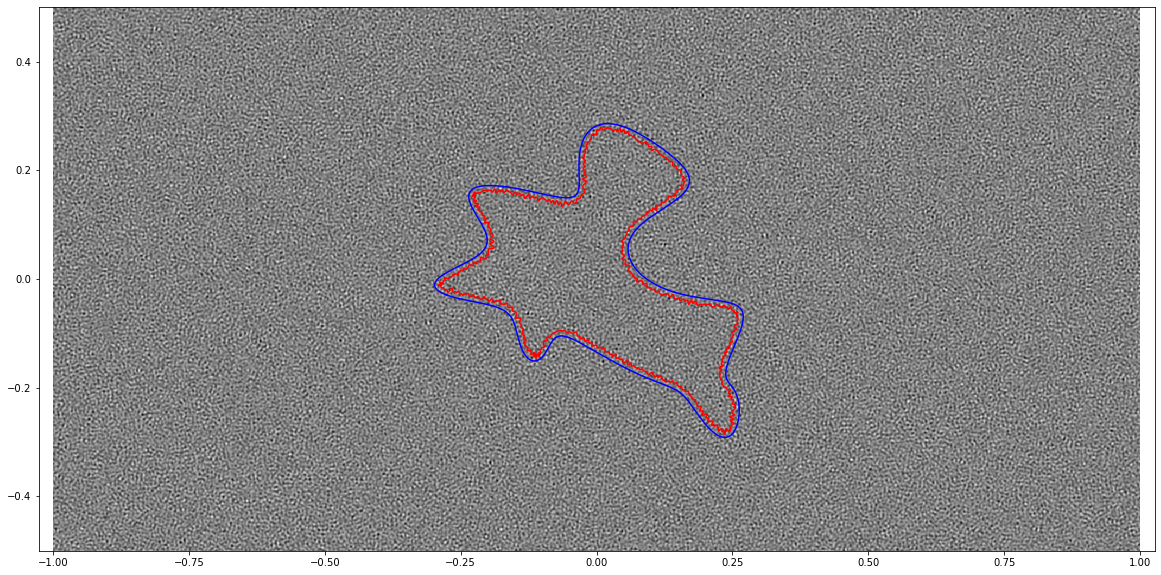

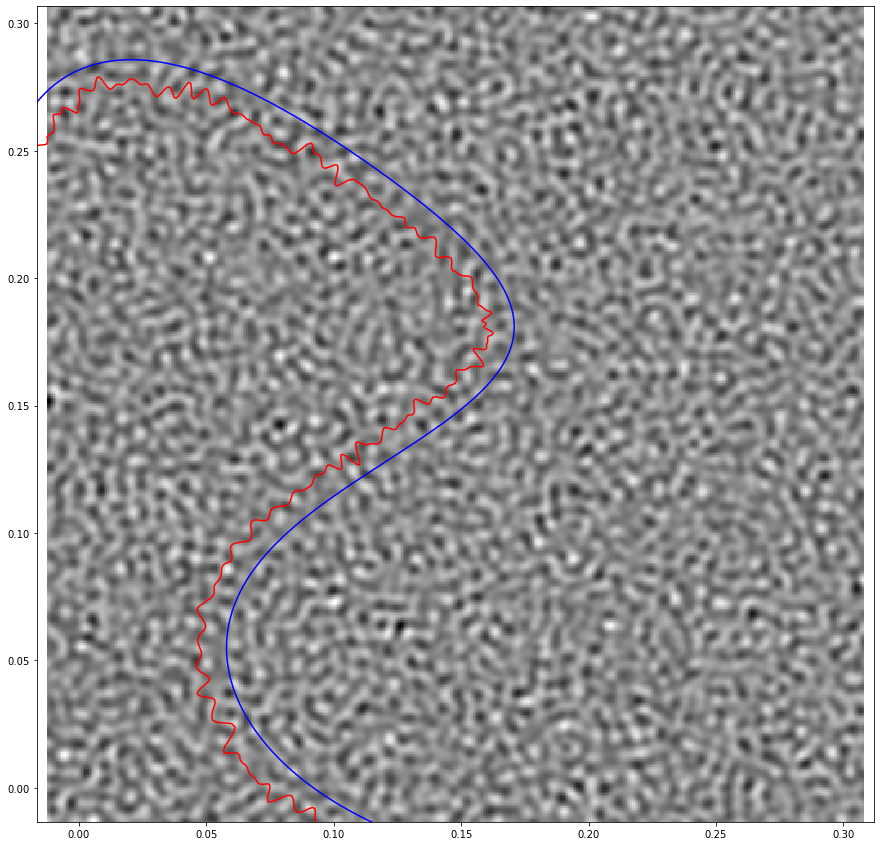

In [3]:
kmax = 1001#2000
L = 0.04#16#0.04
LAmp = 0.0

eps = 0.008
epsAmp = 0.02

a = 1/2
dom = [[-1,1], [-a, a]]

lerp, x, y = fourierGP_2D_lerp(kmax, kmax, L, LAmp, eps, epsAmp, dom)
X,Y = np.meshgrid(x, y)

#p = 1
#corner = lambda x,y : np.exp(-(1e-3**p)/(np.abs(np.abs(x)-.3)**2+np.abs(np.abs(y)-.3)**2)**p)
#x_s, y_s, x_n, y_n = square(500)
x_s, y_s, x_n, y_n = loop(8000, 0.3)
d_s = lerp(x_s, y_s) #* 3 * corner(x_s, y_s)


# FIeld
plt.figure(figsize=(20,10))
plt.pcolormesh(X, Y, lerp.Z, cmap='gray')
plt.plot(x_s - d_s * x_n, y_s - d_s * y_n, 'r')
plt.plot(x_s, y_s, 'b')
plt.axis('equal')
plt.xlim(*dom[0])
plt.ylim(*dom[1])


# Zoom
plt.figure(figsize=(15, 15))
w = 20
x0 = x_s[0]
y0 = y_s[0]
zoomdom = [[x0-eps*w, x0+eps*w], [y0-eps*w, y0+eps*w]]
xz = np.linspace(*zoomdom[0], 500)
yz = np.linspace(*zoomdom[1], 500)
Xz, Yz = np.meshgrid(xz, yz)
plt.pcolormesh(Xz, Yz, lerp(Xz.flatten(), Yz.flatten()).reshape(Xz.shape), cmap='gray')

xr, yr = x_s - d_s * x_n, y_s - d_s * y_n
plt.plot(xr, yr, 'r')
plt.plot(x_s, y_s, 'b')
plt.axis('equal')
plt.xlim(*zoomdom[0])
plt.ylim(*zoomdom[1])

<class 'ufl.geometry.FacetNormal'>


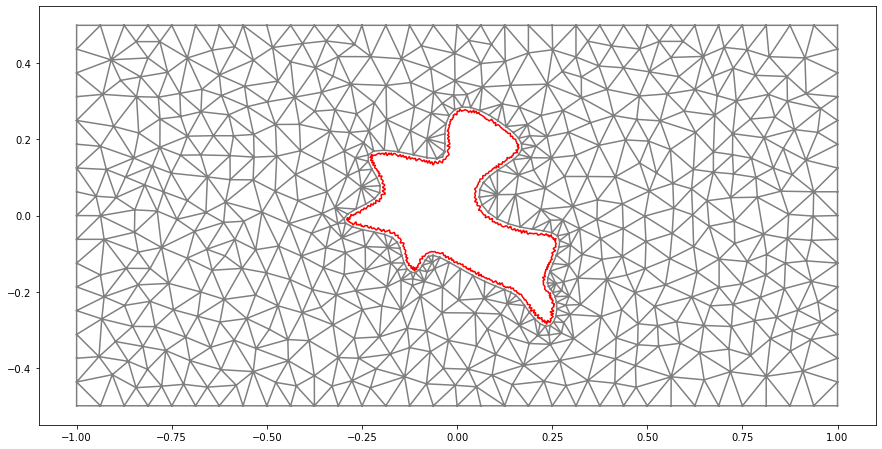

In [4]:


def plot_boundary_mesh(mesh, **kwargs):
    for f in dl.cells(mesh):
        pts = [v.point() for v in dl.vertices(f)]
        plt.plot([pts[0].x(), pts[1].x()], [pts[0].y(), pts[1].y()], **kwargs)

class Blob(dl.SubDomain):
    def inside(self, x, on_boundary):
        #return bool(max(abs(x[0]), abs(x[1])) < 0.4 + dl.DOLFIN_EPS and on_boundary)
        return bool(max(abs(x[0]), abs(x[1]))<0.4)# and on_boundary)

def closest_on_segment(x: dl.Point, v: dl.Cell):
    """Closest distance between point x and line segment ab"""
    (a, b) = [v.point() for v in dl.vertices(v)]
    print(x, a, b)
    ab = b - a
    ax = x - a
    bx = x - b
    if ax.dot(ab) <= 0:
        return a
    elif -bx.dot(ab) <= 0:
        return b
    else:
        return a + ab * (ax.dot(ab) / ab.dot(ab))

pol = to_poly(x_s, y_s, 80)
domain = ms.Rectangle(dl.Point(dom[0][0], dom[1][0]), dl.Point(dom[0][1], dom[1][1])) - pol
mesh  = ms.generate_mesh(domain, resolution=20)
fine_mesh = np.vstack([xr, yr]).T

n = dl.FacetNormal(mesh)
print(type(n))

plt.figure(figsize=(15, 15))
dl.plot(mesh)
plt.plot(fine_mesh[:, 0], fine_mesh[:, 1], color='r')
#plt.xlim(*zoomdom[0])
#plt.ylim(*zoomdom[1])

In [5]:
from util.basis_scaled import ChebBasis, ScaleShiftedBasis, FourBasis
from boundary_solvers.geometry import RoundedMicroGeomGeneric

def generate_boundary_mesh_data(mesh: dl.Mesh, boundary: dl.SubDomain):
    bmesh = dl.BoundaryMesh(mesh, 'exterior')
    sbmesh = dl.SubMesh(bmesh, boundary)
    bbtree = dl.BoundingBoxTree()
    bbtree.build(sbmesh)
    
    boundary_mesh_map = bmesh.entity_map(1)
    submesh_mesh_map = sbmesh.data().array('parent_cell_indices', 1)
    mesh_map = np.array([boundary_mesh_map[submesh_mesh_map[i]] for i in range(len(submesh_mesh_map))])
    return sbmesh, bbtree, mesh_map
    

def closest_boundary_facet(point, boundary_mesh, boundary_tree, boundary_mesh_map, mesh):
    bid, _ = boundary_tree.compute_closest_entity(point)
    facet = dl.Facet(mesh, boundary_mesh_map[bid])
    return facet

def closest_point_on_facet(point, facet):
    pts = [v.point() for v in dl.vertices(facet)]
    a, b = pts
    ab = b - a
    ax = point - a
    bx = point - b
    if ax.dot(ab) <= 0:
        return a
    elif -bx.dot(ab) <= 0:
        return b
    else:
        return a + ab * (ax.dot(ab) / ab.dot(ab))
    
def project_to_boundary(point, boundary_mesh, boundary_tree, boundary_mesh_map, mesh):
    facet = closest_boundary_facet(point, boundary_mesh, boundary_tree, boundary_mesh_map, mesh)
    point = closest_point_on_facet(point, facet)
    normal = facet.normal()
    return point, normal
    
#generate_boundary_mesh_data(mesh, Blob())

Building point search tree to accelerate distance queries.
Computed bounding box tree with 199 nodes for 100 points.


(-0.1, 0.2)

<Figure size 1080x1080 with 0 Axes>

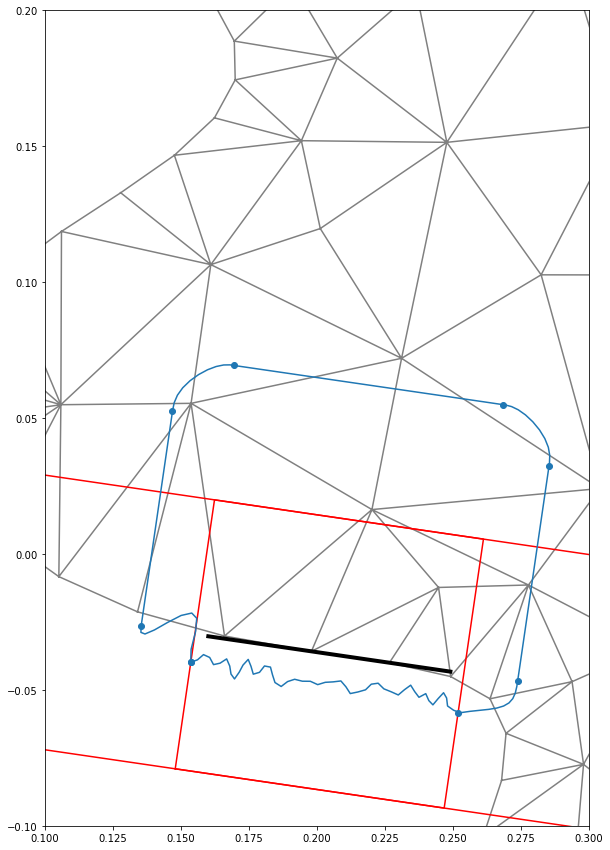

In [6]:
def plot_box(center, normal, width, height, color='red'):
    tangent = -np.array([normal[1], -normal[0]])
    pt_b_l = center - width/2 * tangent + height/2 * normal
    pt_b_r = center + width/2 * tangent + height/2 * normal
    pt_t_r = center + width/2 * tangent - height/2 * normal
    pt_t_l = center - width/2 * tangent - height/2 * normal
    plt.plot([pt_b_l[0], pt_b_r[0], pt_t_r[0], pt_t_l[0], pt_b_l[0]],\
             [pt_b_l[1], pt_b_r[1], pt_t_r[1], pt_t_l[1], pt_b_l[1]], color=color)


class MicroBox(dl.SubDomain):
    def __init__(self, center: dl.Point, normal: dl.Point, width: float, height: float):
        self.center = center
        self.width = width
        self.height = height
        self.tangent = np.array([-normal[1], normal[0]])
        self.normal = normal
        super(MicroBox, self).__init__()
        
    def inside(self, x, on_boundary):
        
        #return bool(max(abs(x[0]), abs(x[1])) < 0.4 + dl.DOLFIN_EPS and on_boundary)
        delta = x - self.center
        return bool( abs(np.dot(delta, self.tangent)) < self.width/2 - dl.DOLFIN_EPS  and
                    abs(np.dot(delta, self.normal)) < self.height/2 - dl.DOLFIN_EPS)

def find_intersection(points, line_point, line_tangent):
    """Find intersection and return the index of point to the right of the intersection, 
    right in the direction of the tangent"""
    line_normal = np.array([line_tangent[1], -line_tangent[0]]) 
    
    for i in range(points.shape[0]-1):
        x0, x1 = points[i], points[i+1]
        dot_0 = np.dot(line_normal, x0 - line_point)
        dot_1 = np.dot(line_normal, x1 - line_point)
        if  dot_0 * dot_1 < 0:
            # find exact intersection
            t = abs(dot_0) / (abs(dot_1) + abs(dot_0))
            intersect = x0 * (1-t) + x1 * t
            # Return right point and intersection
            return intersect, i
        else:
            pass
    raise ValueError("No intersection found, pick a better box")


def order_connected_vertices(mesh_1d):
    """Assuming vertices are connected, order them in the direction of the mesh"""
    mesh_1d.init(0, 1)
    visited = dl.MeshFunction("bool", mesh_1d, False)
    
    start_edge = dl.Edge(mesh_1d, 0)
    visited.array()[start_edge.index()] = True
    
    right_vert = dl.Vertex(mesh_1d, start_edge.entities(0)[1])
    left_vert = dl.Vertex(mesh_1d, start_edge.entities(0)[0])
    indices = [left_vert.index(), right_vert.index()]
    
    # Right search
    while len(right_vert.entities(1)) > 1:
        edge = dl.Edge(mesh_1d, [e for e in right_vert.entities(1) if not visited.array()[e]][0])
        right_vert = dl.Vertex(mesh_1d, [v for v in edge.entities(0) if v != right_vert.index()][0])
        indices = indices + [right_vert.index()]
        visited.array()[edge.index()] = True
    
    # Left search
    while len(left_vert.entities(1))> 1:
        edge = dl.Edge(mesh_1d, [e for e in left_vert.entities(1) if not visited.array()[e]][0])
        left_vert = dl.Vertex(mesh_1d, [v for v in edge.entities(0) if v != left_vert.index()][0])
        indices = [left_vert.index()] + indices
        visited.array()[edge.index()] = True
        
    return indices

def curve_length(curve):
    lengths = np.zeros(curve.shape[0])
    lengths[1:] = np.linalg.norm(curve[1:, :] - curve[:-1, :], axis=1)
    return np.cumsum(lengths)

def reparameterize_curve(curve, length, left_point, right_point, normal, dom):
    p_left, i_left = find_intersection(curve, left_point, normal)
    p_right, i_right = find_intersection(curve, right_point, normal)
    
    l_left = length[i_left] + np.linalg.norm(p_left - curve[i_left])
    l_right = length[i_right] + np.linalg.norm(p_right - curve[i_right])
    
    scale, shift = ScaleShiftedBasis._domain_to_scale_shift([l_left, l_right], dom)
    return scale*(length - shift)
    

def closest_micro_geometry(point, fine_boundary_mesh, boundary_mesh, boundary_tree, boundary_mesh_map, mesh, pad, **geomargs):
    """Find closest point on boundary and normal to boundary at that point, 
    then construct a micro geometry from that point and normal with parameters specified in geomargs,
    normal_roughness must be a function for the offset of the roughness in the normal direction."""
    center, normal = project_to_boundary(dl.Point(point[0], point[1]), boundary_mesh, boundary_tree, boundary_mesh_map, mesh)
    center = center.array()[:2]
    normal = normal.array()[:2]
    tangent = np.array([-normal[1], normal[0]])
    width = geomargs.get('width', 1.0)
    height = geomargs.get('height', 1.0)
    corner_l = center - width * tangent/2
    corner_r = center + width * tangent/2

    bbox = MicroBox(center, normal, width + 2*pad, height+2*pad)
    
    if isinstance(fine_boundary_mesh, dl.Mesh):
        boxMesh = dl.SubMesh(fine_boundary_mesh, bbox)
        indices = order_connected_vertices(boxMesh)
        points = np.array([v[:2] for v in boxMesh.coordinates()])[indices]
    elif isinstance(fine_boundary_mesh, np.ndarray):
        points = fine_boundary_mesh[[bbox.inside(p, True) for p in fine_boundary_mesh]]
    else:
        raise ValueError("fine_boundary_mesh must be either a mesh or a numpy array")
        
    length = curve_length(points)
    t = reparameterize_curve(points, length, corner_l, corner_r, normal, [0, 0.5*np.pi])
    

    f_x = ScaleShiftedBasis.fromSamplesInDomain(t, points[:, 0], [t[0], t[-1]], ChebBasis, dim=len(t)//2)
    df_x = f_x.diff(1)
    ddf_x = f_x.diff(2)
    
    f_y = ScaleShiftedBasis.fromSamplesInDomain(t, points[:, 1], [t[0], t[-1]], ChebBasis, dim=len(t)//2)
    df_y = f_y.diff(1)
    ddf_y = f_y.diff(2)
    
    
    f = lambda t: f_x(t) + 1j * f_y(t)
    df = lambda t: df_x(t) + 1j * df_y(t)
    ddf = lambda t: ddf_x(t) + 1j * ddf_y(t)
    
    center_c = center[0] + 1j * center[1]
    normal_c = normal[0] + 1j * normal[1]
    return RoundedMicroGeomGeneric(f, df, ddf, center=center_c, normal=normal_c, simple_func=False, **geomargs)
    


center = np.array([.21,0])
width = 0.1
height= 0.1
pad = 0.08
corner_w = 0.02

## 
plt.figure(figsize=(15, 15))
boundary_mesh, boundary_tree, boundary_mesh_map = generate_boundary_mesh_data(mesh, Blob())
geom = closest_micro_geometry(center, fine_mesh, boundary_mesh, boundary_tree, boundary_mesh_map, mesh, pad=0.5*width,
                               width=width, height=height, corner_w=corner_w, n_refine=0)

center = np.array([geom.center.real, geom.center.imag])
normal = np.array([geom.norm.real, geom.norm.imag])


plt.figure(figsize=(15, 15))
dl.plot(mesh)
plot_box(center, normal, width+2*pad, height, color='red')
plot_box(center, normal, width, height, color='red')
geom.plot(plt.gca(), showsegments=True)

plt.xlim([0.1, 0.3])
plt.ylim([-0.1, 0.2])


Building point search tree to accelerate distance queries.
Computed bounding box tree with 199 nodes for 100 points.


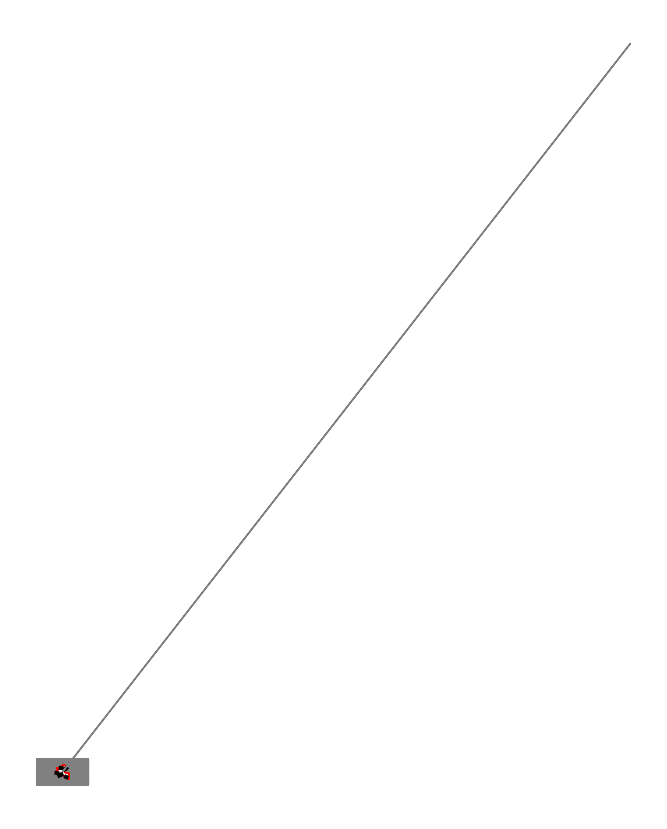

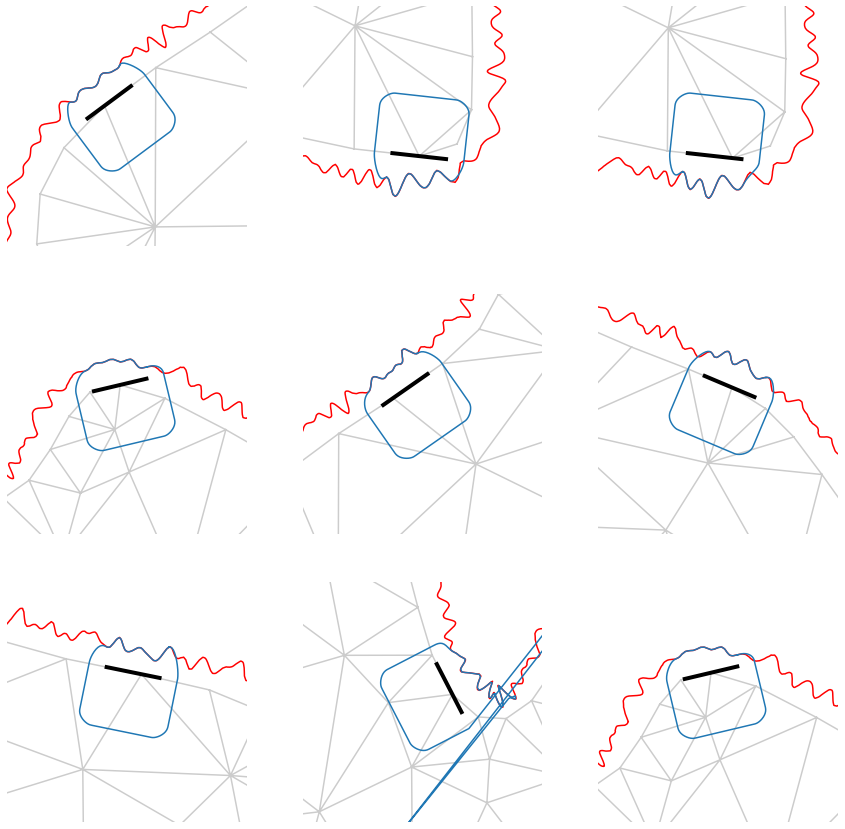

In [13]:
n = 3
scale = eps*3
x_mic = np.random.uniform(-0.25, 0.25, n*n)
y_mic = np.random.uniform(-0.25, 0.25, n*n)

plt.figure(figsize=(15, 15))
dl.plot(mesh)
remove_axes(plt.gca())
plt.plot(xr, yr, 'r')

plt.figure(figsize=(15, 15))

geoms = []
meshdata = generate_boundary_mesh_data(mesh, Blob())
for i, (xm, ym) in enumerate(zip(x_mic, y_mic)):
    geom = closest_micro_geometry(dl.Point(xm, ym), fine_mesh, *meshdata, mesh, pad=scale/2,
                                  width=scale, height=scale, corner_w=scale/4, n_refine=3)
    geoms.append(geom)
    
    #print(f"Test {i}", end="\r")
    #test_adjoint(geom)
    
    #z = geom.inner_point
    #x, y = z.real, z.imag
    plt.figure(1)
    geom.plot(plt.gca())
    
    plt.figure(2)
    plt.subplot(n,n,i+1)
    z = geom.inner_point
    xm, ym = z.real, z.imag
    dl.plot(mesh, alpha=0.4)
    plt.plot(xr, yr, 'r')
    geom.plot(plt.gca(), showsegments=False)
    plt.xlim([xm-scale*2, xm+scale*2])
    plt.ylim([ym-scale*2, ym+scale*2])
    remove_axes(plt.gca())

In [8]:
import sys
sys.path.append('../tests/')
import pytest as pt

!pytest "/home/emastr/phd/tests/" #test_geometry.py"

============================= test session starts ==============================
platform linux -- Python 3.8.12, pytest-7.3.1, pluggy-1.0.0
rootdir: /home/emastr/phd
collected 1 item                                                               

../tests/test_geometry.py .                                              [100%]

=============================== warnings summary ===============================
tests/test_geometry.py::test_adjoint
tests/test_geometry.py::test_adjoint
  <decorator-gen-5>:2: DeprecationWarning: scipy.sparse.linalg.gmres called without specifying `atol`. The default value will be changed in a future release. For compatibility, specify a value for `atol` explicitly, e.g., ``gmres(..., atol=0)``, or to retain the old behavior ``gmres(..., atol='legacy')``

-- Docs: https://docs.pytest.org/en/stable/how-to/capture-warnings.html
======================== 1 passed, 2 warnings in 5.91s =========================
